In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('shopee_reviews_clean.csv')

In [ ]:
df.head()  # Display the first few rows of the DataFrame


,content,score,clean_review
0,"Barang sesuai dengan deskripsi, bahan 0k sanga...",5,barang sesuai dengan deskripsi bahan k sangat ...
1,ini pihak shopee ngga mempertimbangkan keluhan...,2,ini pihak shopee ngga timbang keluh cust kah b...
2,bagus sih aplikasinya.. klu bisa di tingkat ka...,4,bagus sih aplikasi klu bisa di tingkat kan lag...
3,Pengalaman untuk pembelian di Shopee ini bagus...,5,alam untuk beli di shopee ini bagus dan sana c...
4,Buka aplikasi langsung autoplay video orang te...,1,buka aplikasi langsung autoplay video orang te...


In [4]:
def label_sentiment(rating):
    if rating <= 2:
        return "negatif"
    elif rating == 3:
        return "netral"
    else:
        return "positif"

df['label'] = df['score'].apply(label_sentiment)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fill missing values in 'clean_review' with empty string
df['clean_review'] = df['clean_review'].fillna('')

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_review'])

sequences = tokenizer.texts_to_sequences(df['clean_review'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate

input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=100)(input_layer)

conv_3 = Conv1D(128, 3, activation='relu')(embedding_layer)
conv_4 = Conv1D(128, 4, activation='relu')(embedding_layer)
conv_5 = Conv1D(128, 5, activation='relu')(embedding_layer)

pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

concat = Concatenate()([pool_3, pool_4, pool_5])
drop = Dropout(0.5)(concat)
dense = Dense(64, activation='relu')(drop)
output = Dense(3, activation='softmax')(dense)  # 3 kelas

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded, df['label_enc'], test_size=0.2, stratify=df['label_enc'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.7802 - loss: 0.5705 - val_accuracy: 0.8024 - val_loss: 0.5153
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8107 - loss: 0.4975 - val_accuracy: 0.8065 - val_loss: 0.5048
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.8243 - loss: 0.4579 - val_accuracy: 0.8064 - val_loss: 0.5079
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8369 - loss: 0.4190 - val_accuracy: 0.8022 - val_loss: 0.5279
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8509 - loss: 0.3794 - val_accuracy: 0.7981 - val_loss: 0.5731
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8664 - loss: 0.3389 - val_accuracy: 0.7888 - val_loss: 0.5931
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.8807 - loss: 0.3016 - val_accuracy: 0.7798 - val_loss: 0.6556
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.8955 -

In [10]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi: {acc * 100:.2f}%")


507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7677 - loss: 0.8586
Akurasi: 76.77%


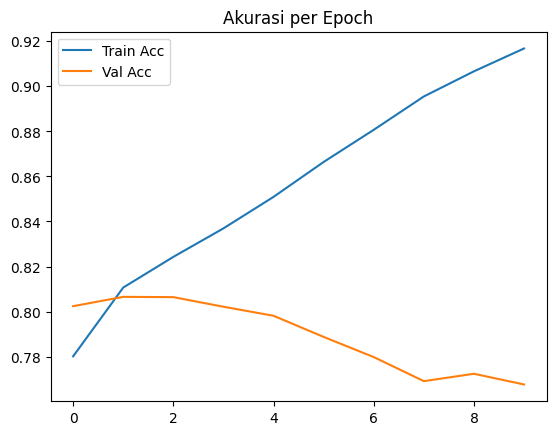

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Akurasi per Epoch")
plt.show()

507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

     negatif       0.75      0.82      0.78      6641
      netral       0.20      0.16      0.18      1419
     positif       0.86      0.83      0.85      8140

    accuracy                           0.77     16200
   macro avg       0.61      0.60      0.60     16200
weighted avg       0.76      0.77      0.76     16200



<Axes: >

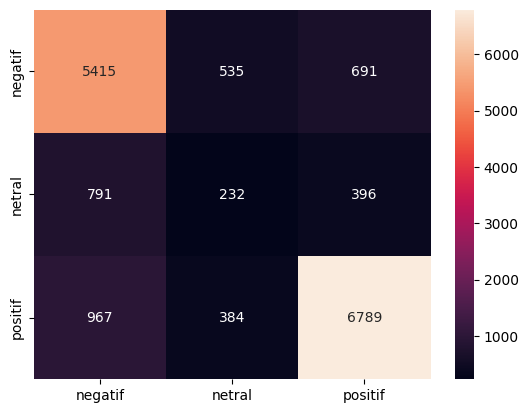

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
